In [0]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 317 (delta 9), reused 14 (delta 5), pack-reused 297
Receiving objects: 100% (317/317), 541.74 KiB | 4.88 MiB/s, done.
Resolving deltas: 100% (181/181), done.
/content/emotenn


# Feature generation

In [0]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
from emotenn import constants as ct, gen_utils as gu, load_utils as lu

In [0]:
for archive in [ct.RAVDESS_SPEECH, ct.RAVDESS_SONG]:
    lu.download_file_from_google_drive(archive, exist_ok=True)
    gu.unpack(archive.path)

In [0]:
sound_files_pattern = os.path.join(ct.UNPACKED_DIR, 'Audio_*_Actors_01-24', '**', '*.wav')
sound_files = glob.glob(sound_files_pattern, recursive=True)

In [0]:
labels = []
for sound_path in sound_files:
    name = os.path.basename(sound_path)
    emotion = name[6:8]
    if emotion in ['01', '02']:
        label = 'Neutral'
    elif emotion == '03':
        label = 'Happy'
    elif emotion == '04':
        label = 'Sad'
    elif emotion == '05':
        label = 'Angry'
    elif emotion == '06':
        label = 'Fear'
    elif emotion == '07':
        label = 'Disgust'
    elif emotion == '08':
        label = 'Surprise'
    labels.append(label)
dummies = pd.get_dummies(labels)[ct.CLASS_NAMES]
Y = dummies.to_numpy(dtype='float32')

In [0]:
def normalize_mfcc(mfcc):
    mean = np.mean(mfcc, axis=1)
    std = np.std(mfcc, axis=1)
    mfcc = mfcc.transpose()
    mfcc -= mean
    mfcc /= std
    return mfcc.transpose()

In [0]:
mfcc_features = []
mfcc_number = 40
for sound_path in sound_files:
    y, sample_rate = librosa.load(sound_path, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=mfcc_number)
    #mfcc = normalize_mfcc(mfcc)
    mfcc_features.append(mfcc)

In [0]:
# Fill missing elements with zeros
result_shape = max([mfcc.shape for mfcc in mfcc_features])
X = []
for mfcc in mfcc_features:
    z = np.zeros((mfcc.shape[0], result_shape[1] - mfcc.shape[1]), dtype=mfcc.dtype)
    X.append(np.concatenate((mfcc,z), axis=1))
X = np.asarray(X)
print(f'Dataset shape: {X.shape}')

Dataset shape: (2452, 40, 216)


In [0]:
gu.save(X, Y, 'ravdess-40-orig')

Generated 2452 items
Data saved in /content/emotenn/datasets/ravdess-40-orig.bin


# Training and classification

## Import the required libraries

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from emotenn import constants as ct, train_utils as tu, load_utils as lu, plot_utils as pu, gen_utils as gu

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks

## Download and preprocess dataset

In [0]:
def load_from_disk(name):
    dataset_path = os.path.join(ct.DATASETS_DIR, name) + '.bin'
    with open(dataset_path, 'rb') as dataset_file:
        X = np.load(dataset_file)
        Y = np.load(dataset_file)
    return X, Y

In [0]:
#X, Y = lu.load_dataset(ct.RAVDESS)
#X, Y = load_from_disk('ravdess-40-orig')
#X, Y = load_from_disk('ravdess-40')
X_orig, Y = lu.load_dataset(ct.GDriveFile('18Wq6sBNFo-zaTdqN3wR0J_bJLOtZhFSn', os.path.join(ct.DATASETS_DIR, 'ravdess-40-orig.bin')))
#X_orig, Y = lu.load_dataset(ct.GDriveFile('11HwnPtd--Vp2xPmXItEn2hKaWdXKLwSu', os.path.join(ct.DATASETS_DIR, 'ravdess-40.bin')))

X = []
for x in X_orig:
    mfcc = np.mean(x, axis=1)
    X.append(mfcc)
X = np.asarray(X, dtype=np.float32)
X = np.expand_dims(X, -1)

split = tu.split_dataset(X, Y, test_size=0.15, valid_size=0.2, align_by=16)
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split
print(f'Data dimensions: {X.shape}')

Data dimensions: (2452, 40, 1)


## Initialize utility functions and variables

In [0]:
def display_results(model, history):
    for name, x, y in [('Train', X_train, Y_train), ('Validation', X_valid, Y_valid), ('Test', X_test, Y_test)]:
        score = model.evaluate(x, y)
        print("{} dataset {}: {:.2f}%".format(name, model.metrics_names[1], score[1] * 100))
    pu.plot_model_history(history.history)
    pu.plot_confusion_matrix(model, X_test, Y_test)

def train(model, batch_size=64, epochs=300, cb=None):
    return model.fit(X_train, 
                     Y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_valid, Y_valid),
                     callbacks=cb,
                     shuffle=True)

In [0]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Initializing the TPU system: grpc://10.81.223.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.81.223.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## 1D CNN Base

In [0]:
def build_cnn_1d(optimizer, l2=None):
    with strategy.scope():
        model = Sequential()
        model.add(Input(X.shape[1:]))
        model.add(Conv1D(128, 5, padding='same'))
        model.add(Activation('relu'))
        model.add(Dropout(0.1))
    
        model.add(MaxPooling1D(pool_size=(8)))
        model.add(Conv1D(128, 5, padding='same',))
        model.add(Activation('relu'))
        model.add(Dropout(0.1))
    
        model.add(Flatten())
        model.add(Dense(7))
        model.add(Activation('softmax'))

        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
#tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
#cb = [callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]
cb = None

cnn_base = build_cnn_1d(optimizer)
cnn_base_history = train(cnn_base, batch_size=16, epochs=1000, cb=cb)
tu.save_results(cnn_base, cnn_base_history, f'cnn-base')

Epoch 1/1000
99/99 [==============================] - 1s 15ms/step - accuracy: 0.1610 - loss: 6.9234 - val_accuracy: 0.1855 - val_loss: 3.1781
Epoch 2/1000
99/99 [==============================] - 1s 14ms/step - accuracy: 0.1793 - loss: 5.3477 - val_accuracy: 0.2016 - val_loss: 2.0277
Epoch 3/1000
99/99 [==============================] - 1s 14ms/step - accuracy: 0.1919 - loss: 4.6561 - val_accuracy: 0.2581 - val_loss: 1.9846
Epoch 4/1000
99/99 [==============================] - 1s 14ms/step - accuracy: 0.2001 - loss: 4.0624 - val_accuracy: 0.3165 - val_loss: 1.9123
Epoch 5/1000
99/99 [==============================] - 1s 14ms/step - accuracy: 0.2077 - loss: 3.5840 - val_accuracy: 0.3226 - val_loss: 1.8175
Epoch 6/1000
99/99 [==============================] - 1s 14ms/step - accuracy: 0.2323 - loss: 3.2078 - val_accuracy: 0.3427 - val_loss: 1.7644
Epoch 7/1000
99/99 [==============================] - 1s 13ms/step - accuracy: 0.2355 - loss: 2.7844 - val_accuracy: 0.3427 - val_loss: 1.6259

50/50 [==============================] - 1s 11ms/step - accuracy: 0.9912 - loss: 0.0650
Train dataset accuracy: 99.12%
16/16 [==============================] - 0s 8ms/step - accuracy: 0.7278 - loss: 0.8866
Validation dataset accuracy: 72.78%
12/12 [==============================] - 0s 22ms/step - accuracy: 0.7097 - loss: 1.0479
Test dataset accuracy: 70.97%


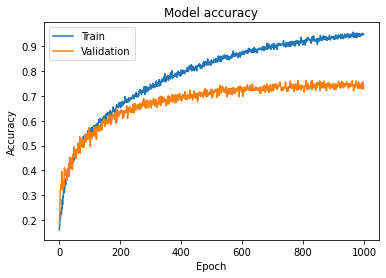

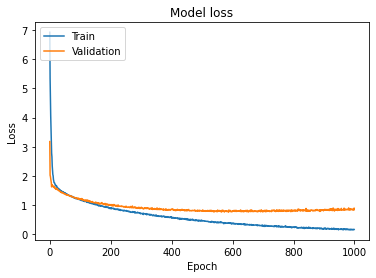

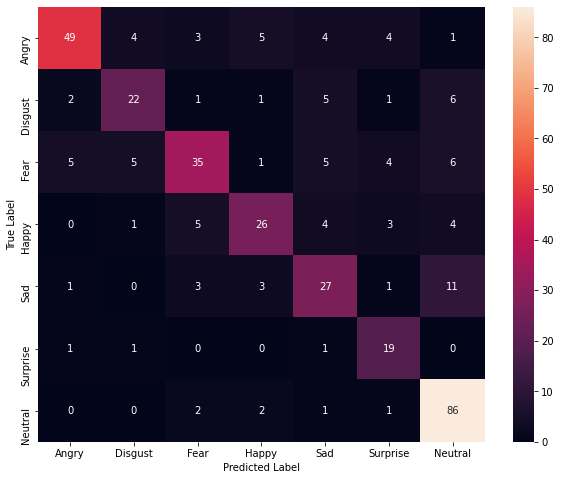

In [0]:
display_results(cnn_base, cnn_base_history)

# Test with random audio

In [0]:
import librosa
from IPython.display import Audio
from emotenn import audio_utils as au

In [0]:
def show_mfcc(features):
    plt.imshow(features, aspect='auto')

In [0]:
audio = au.record_audio(sec=5)
audio_path = '/content/tmp.wav'
with open(audio_path, 'wb') as f:
    f.write(audio.data)

audio

CNN Base: Happy


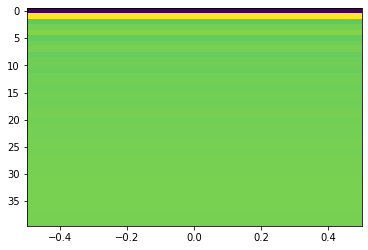

In [0]:
y, sample_rate = librosa.load(audio_path, res_type='kaiser_fast')
mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=40)
#mfcc = normalize_mfcc(mfcc)
mfcc = np.mean(mfcc, axis=1)
mfcc = np.reshape(mfcc, (1, 40, 1))
show_mfcc(mfcc[0])

class_idx = cnn_base.predict_classes(mfcc)[0]
print('CNN Base: ' + ct.CLASS_NAMES[class_idx])

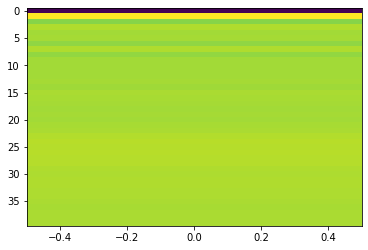

In [0]:
show_mfcc(X[1])